# Denoising Autoencoder

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Parameters
learning_rate = 0.01
epochs = 100
batch_size = 256
display_step = 100

# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5

In [4]:
img = mnist.train.images[2]

# Add random noise to the input images
noisy_imgs = img + noise_factor * np.random.randn(*img.shape)
# Clip the images to be between 0 and 1
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

Text(0.5,1,'noise_factor =0.5')

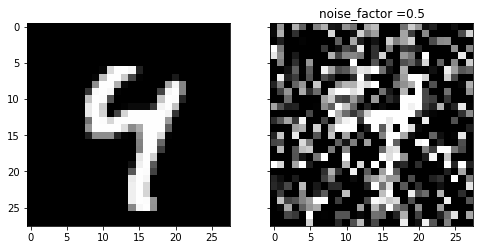

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,12))
axes[0].imshow(img.reshape((28, 28)), cmap='Greys_r')
axes[1].imshow(noisy_imgs.reshape((28, 28)), cmap='Greys_r')
axes[1].set_title('noise_factor ={}'.format(noise_factor))

In [6]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

In [7]:
### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

In [8]:
### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8

conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8

upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8

conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8

upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8

conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

In [9]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
#loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [10]:
sess = tf.InteractiveSession()

In [11]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [12]:
sess.run(init)

In [13]:
vloss = []
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})
        vloss.append(batch_cost)
        if ii % display_step == 0 or ii == 1:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6960
Epoch: 1/100... Training loss: 0.6449
Epoch: 1/100... Training loss: 0.2402
Epoch: 1/100... Training loss: 0.1990
Epoch: 2/100... Training loss: 0.2026
Epoch: 2/100... Training loss: 0.2061
Epoch: 2/100... Training loss: 0.1778
Epoch: 2/100... Training loss: 0.1830
Epoch: 3/100... Training loss: 0.1784
Epoch: 3/100... Training loss: 0.1858
Epoch: 3/100... Training loss: 0.1769
Epoch: 3/100... Training loss: 0.1672
Epoch: 4/100... Training loss: 0.1700
Epoch: 4/100... Training loss: 0.1691
Epoch: 4/100... Training loss: 0.1642
Epoch: 4/100... Training loss: 0.1614
Epoch: 5/100... Training loss: 0.1584
Epoch: 5/100... Training loss: 0.1578
Epoch: 5/100... Training loss: 0.1598
Epoch: 5/100... Training loss: 0.1520
Epoch: 6/100... Training loss: 0.1609
Epoch: 6/100... Training loss: 0.1584
Epoch: 6/100... Training loss: 0.1533
Epoch: 6/100... Training loss: 0.1584
Epoch: 7/100... Training loss: 0.1551
Epoch: 7/100... Training loss: 0.1533
Epoch: 7/100

Epoch: 53/100... Training loss: 0.1324
Epoch: 54/100... Training loss: 0.1337
Epoch: 54/100... Training loss: 0.1339
Epoch: 54/100... Training loss: 0.1341
Epoch: 54/100... Training loss: 0.1353
Epoch: 55/100... Training loss: 0.1345
Epoch: 55/100... Training loss: 0.1336
Epoch: 55/100... Training loss: 0.1322
Epoch: 55/100... Training loss: 0.1348
Epoch: 56/100... Training loss: 0.1416
Epoch: 56/100... Training loss: 0.1354
Epoch: 56/100... Training loss: 0.1329
Epoch: 56/100... Training loss: 0.1373
Epoch: 57/100... Training loss: 0.1362
Epoch: 57/100... Training loss: 0.1393
Epoch: 57/100... Training loss: 0.1304
Epoch: 57/100... Training loss: 0.1353
Epoch: 58/100... Training loss: 0.1346
Epoch: 58/100... Training loss: 0.1362
Epoch: 58/100... Training loss: 0.1327
Epoch: 58/100... Training loss: 0.1339
Epoch: 59/100... Training loss: 0.1345
Epoch: 59/100... Training loss: 0.1355
Epoch: 59/100... Training loss: 0.1341
Epoch: 59/100... Training loss: 0.1319
Epoch: 60/100... Training

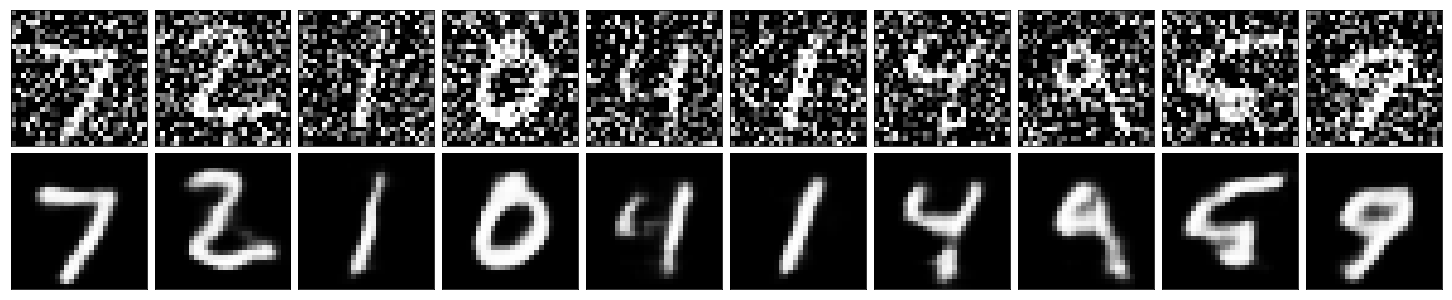

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

### References
* https://github.com/nvmoyar/autoencoders/blob/master/Convolutional_Autoencoder_MNIST.ipynb